In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import numpy as np

from keras.callbacks import ReduceLROnPlateau
from keras.models import Model, load_model
from keras.optimizers import SGD, Adam 
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, GlobalMaxPooling2D, Flatten, Concatenate, Conv2D, Input, Flatten, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, Reshape, BatchNormalization

from keras.applications.vgg16 import VGG16

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [31]:
from src.utils.preprocess import DataGenerator
from src.utils.callbacks import PlotCurves
from src.utils.load_data import load_data
from src.utils.comparams import auc
from src.utils.tester import run_test

In [4]:
del_vars = False

### Data Generator

In [5]:
data_dir = './data/macenko/'

In [6]:
x_train, y_train, x_valid, y_valid = load_data(data_dir, purpose='train', 
                                               limit=None, val_limit=None, norm='macenko')
len(x_train), len(x_valid)

(261756, 32728)

In [7]:
# indexes
train_id = np.arange(len(x_train))
val_id = np.arange(len(x_valid))

# create a useful dictionary structures
partition = {}
partition['train'] = train_id
partition['validation'] = val_id
    
train_labels = {str(i) : y_train[i].flatten()[0] for i in train_id}
val_labels = {str(i) : y_valid[i].flatten()[0] for i in val_id}

In [8]:
if del_vars:
    del train_id
    del val_id
    del data_dir

## MODEL

In [14]:
input_shape = (224,224,3)

In [15]:
def build_arch_8_net(input_shape=(96,96,3)):
    
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = vgg16.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    y = Dense(2, activation='softmax')(x) # sigmoid instead of softmax to have independent probabilities
    model = Model(inputs=vgg16.input, outputs=y)
    
    # Train only the top layer
    for layer in vgg16.layers:
        layer.trainable = False

    return model

In [16]:
model = build_arch_8_net(input_shape)

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Compile

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_auc', 
                                            patience=2,
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000005)

In [19]:
optimizer = Adam(lr=0.001)
loss = 'binary_crossentropy'
metrics = ['acc', auc]

In [20]:
model.compile(optimizer, loss, metrics)

W0617 19:53:19.552645 139937156919424 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0617 19:53:19.557531 139937156919424 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3378: The name tf.nn.sigmoid_cross_entropy_with_logits is deprecated. Please use tf.nn.sigmoid_cross_entropy_with_logits instead.

W0617 19:53:19.558749 139937156919424 deprecation.py:323] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:179: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0617 19:53:19.569

#### Load Model

## Train the model

In [21]:
model_name = 'vgg16_model_bin_cross_arch_8_lr_0_001_inp224_randAug'

In [22]:
batch_size = 128
n_epoch = 15

# Parameters for generators
train_params = {
    'dim': (input_shape[0], input_shape[1]),
    'batch_size': batch_size,
    'n_classes': 2,
    'aug': True,
    'shuffle': True
}

val_params = {
    'dim': (input_shape[0], input_shape[1]),
    'batch_size': batch_size,
    'n_classes': 2,
    'aug': False,
    'shuffle': True
}

# Generators
training_generator = DataGenerator(partition['train'], x_train, train_labels, **train_params)
validation_generator = DataGenerator(partition['validation'], x_valid, val_labels, **val_params)


# Callbacks
callbacks = [PlotCurves(model_name=model_name), learning_rate_reduction]

In [23]:
if del_vars:
    del x_train
    del x_valid
    del y_train
    del y_valid
    del train_labels
    del val_labels

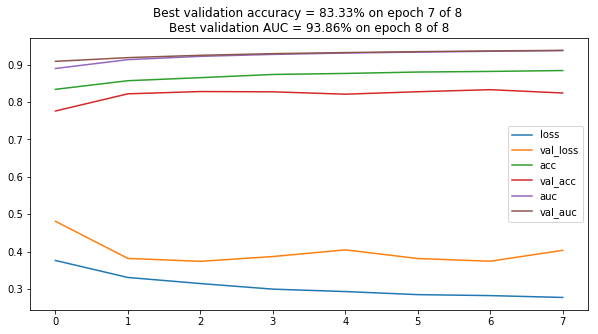

Epoch 9/15
1575/2044 [======================>.......] - ETA: 2:51 - loss: 0.2756 - acc: 0.8851 - auc: 0.9390

KeyboardInterrupt: 

In [24]:
# Random Aug inp 224
model.fit_generator(training_generator, validation_data=validation_generator,
                    epochs=n_epoch, callbacks=callbacks)

In [32]:
run_test('./Model/vgg16_model_bin_cross_arch_8_lr_0_001_inp224_randAug/vgg16_model_bin_cross_arch_8_lr_0_001_inp224_randAug_epoch_8.h5',
        input_shape=(224,224))

sklearn auc: 0.914624675425176
tf auc: [0.91449976, 0.91449976]


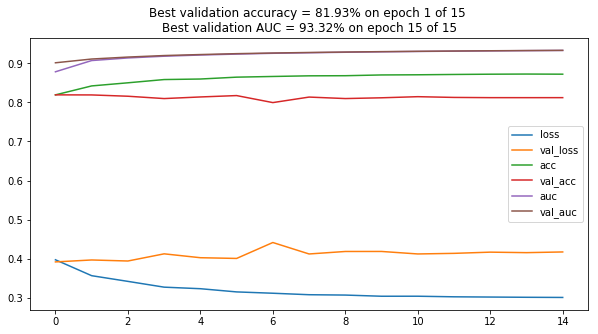


Epoch 00015: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.


In [19]:
# Random Aug inp 96
model.fit_generator(training_generator, validation_data=validation_generator,
                    epochs=n_epoch, callbacks=callbacks)

In [20]:
run_test('./Model/vgg16_model_bin_cross_arch_8_lr_0_001_inp224_randAug/vgg16_model_bin_cross_arch_8_lr_0_001_inp96_randAug_epoch_15.h5')

sklearn auc: 0.895237933347593
tf auc: [0.8952257, 0.8952257]


### 10k Experiments

#### Random Aug

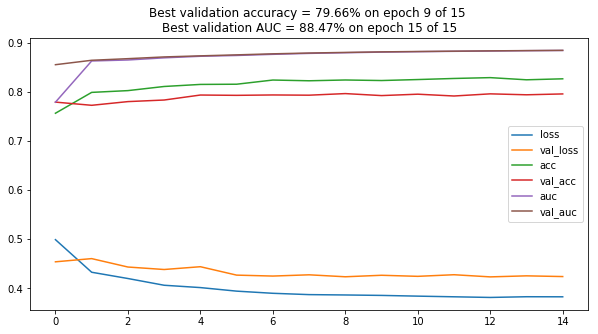


Epoch 00015: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.


In [19]:
# 10k: Random Aug
model.fit_generator(training_generator, validation_data=validation_generator,
                    epochs=n_epoch, callbacks=callbacks)

In [20]:
run_test('./Model/vgg16_model_bin_cross_arch_8_lr_0_001_inp96_randAug/vgg16_model_bin_cross_arch_8_lr_0_001_inp96_randAug_epoch_15.h5')

sklearn auc: 0.8825715510025844
tf auc: [0.8825625, 0.8825625]


#### No Augmentation

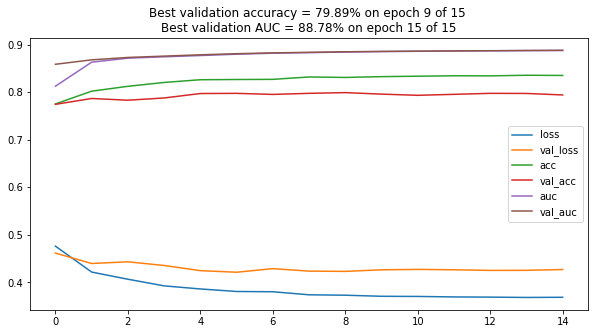


Epoch 00015: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.


In [19]:
# 10k: No aug
model.fit_generator(training_generator, validation_data=validation_generator,
                    epochs=n_epoch, callbacks=callbacks)

In [20]:
run_test('./Model/vgg16_model_bin_cross_arch_8_lr_0_001_inp96_no_Aug/vgg16_model_bin_cross_arch_8_lr_0_001_inp96_no_Aug_epoch_15.h5')

sklearn auc: 0.8809530648093677
tf auc: [0.8809217, 0.8809217]


#### Elastic Trans Augmented

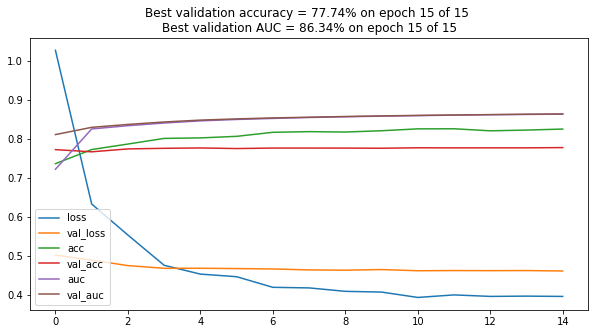


Epoch 00015: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.


In [19]:
# 10k: elast_a=[0, 0.75], elast_sig=0.25
model.fit_generator(training_generator, validation_data=validation_generator,
                    epochs=n_epoch, callbacks=callbacks)

In [20]:
run_test('./Model/vgg16_model_bin_cross_arch_8_lr_0_001_inp96_elst2/vgg16_model_bin_cross_arch_8_lr_0_001_inp96_elst2_epoch_15.h5')

sklearn auc: 0.8710949334638258
tf auc: [0.8710759, 0.8710759]


#### Elastic Trans Augmented

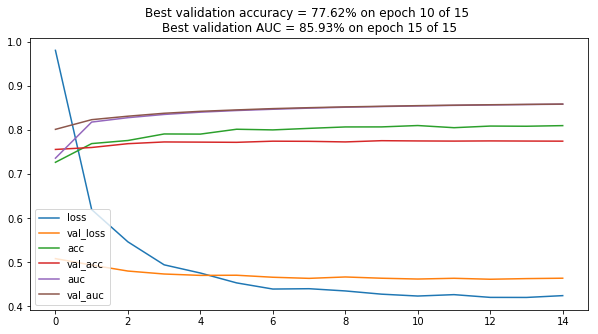


Epoch 00015: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.


In [25]:
# 10k: elast_a=[80, 120], elast_sig=[9.0 , 11.0]
model.fit_generator(training_generator, validation_data=validation_generator,
                    epochs=n_epoch, callbacks=callbacks)

In [30]:
run_test('./Model/vgg16_model_bin_cross_arch_8_lr_0_001_inp96_elst/vgg16_model_bin_cross_arch_8_lr_0_001_inp96_elst_epoch_15.h5')

sklearn auc: 0.8712118982873225
tf auc: [0.87120986, 0.87120986]


## Archive

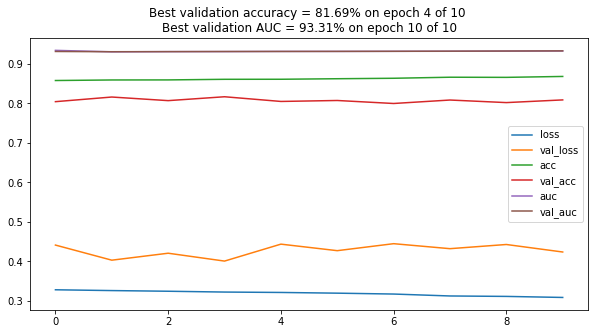

2044/2044 [==============================] - 1127s 552ms/step - loss: 0.3087 - acc: 0.8683 - auc: 0.9329 - val_loss: 0.4238 - val_acc: 0.8089 - val_auc: 0.9331


In [22]:
# vgg16_model_bin_cross_arch_8_lr_0_001_inp96_10ep20ep
# Training - limitless - macenko - augmented
model.fit_generator(training_generator, validation_data=validation_generator,
                    epochs=n_epoch, callbacks=callbacks)